In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import math
import seaborn as sns

os.chdir(  "/Users/etmu9498/research/code/scripts")
import tc_metadata
import make_plots
import make_plots_new_heights
import helper_fns
import cloud_height

os.chdir(  "/Users/etmu9498/research/code/scripts/plotting")
import simple_flight_level_plot

In [2]:
# setup
tcname = 'sam'
dataset = 5
metadata = tc_metadata.all_data( tcname)

# load crl data
tdr_name, crl_name = tc_metadata.choose_new_data( tcname, dataset)
crl_path =  "/Users/etmu9498/research/data/crl-new-matrices"
os.chdir( crl_path)
crl_data = xr.open_dataset( crl_name)

# load flight level data
flight_name = tc_metadata.choose_new_in_situ_name( tcname, dataset)
flight_path = "/Users/etmu9498/research/data/in-situ-new"
os.chdir( flight_path)
flight_data = xr.open_dataset( flight_name)


In [3]:
# find the center point of the eye: equal number of data points to the left as to the right
lim0 = metadata['eyewall_dists_no_eyewalls'][dataset][0]
lim1 = metadata['eyewall_dists_no_eyewalls'][dataset][1]
dist = crl_data.in_situ_distance
# the indices closest to lim0 and lim1
ind0 = (np.abs(crl_data.in_situ_distance - lim0 )).argmin().values
ind1 = (np.abs(crl_data.in_situ_distance - lim1 )).argmin().values


# trim down distance axis to look at the eye
trimdist = dist[ ind0: ind1]

# find the eye center
# even case
if len( trimdist.values) % 2 == 0:
    small_ind = len( trimdist.values) / 2
# odd length of xaxis case
else:
    # math.ceil rounds the division up to get the center int!
    small_ind = math.ceil( len( trimdist.values) / 2)
    
# add all the indices before the first eyewall to get a properly spaced tc center
# the values below are used to plot the tc center below
startdist = dist[ np.where( dist.values <= lim0)]
center_ind = int( len( startdist.values) + small_ind )
center_dist = dist[ center_ind]

In [4]:
##########################
## simpler and probably better way of doing things!! just initialize both sides of the rmw at once
##########################

rmwaxis = np.linspace( -1, 1, num=len( dist[ ind0:ind1]))


# find inds closest to rmw = +-.5
# add distance to ind = 0 for eyewall like above!
ind_minus5 = (np.abs(rmwaxis + .5 )).argmin() + len( startdist.values)
ind_plus5 = (np.abs(rmwaxis - .5 )).argmin() + len( startdist.values)

In [5]:
# find cloud heights for current eye
H, xaxis_value = cloud_height.find_cloud_heights( crl_name, -30, ind0, ind1, xaxis ='in-situ-dist', crl_path=crl_path, new_heights=True)

# break the distribution down by rmw distance!
lowrmw = []
highrmw = []
# cycle through every case
for i in range( len( H)):
    
    # high rmw case: add cloud heights
    if rmwaxis[ i] > .5 or rmwaxis[ i] < -.5:
        highrmw.append( H[ i])
    # low rmw case
    else:
        lowrmw.append( H[ i])

In [6]:
# maybe try calculating a kde manually rather than using seaborn? I feel like I don't have enough
# of a handle on the data when using that method.

Text(0.5, 0, 'Distance from TC Center (km)')

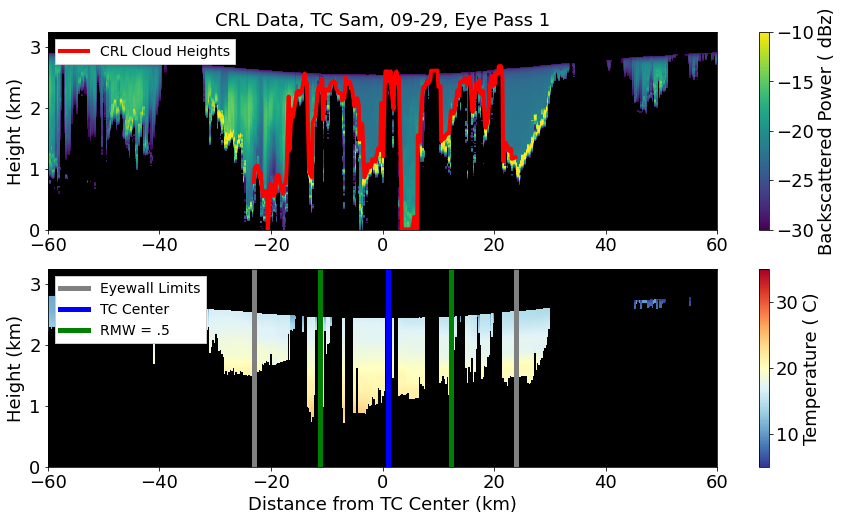

In [8]:
# make test plots! (code below is based off scripts found in plotting/plot_rmw_chosen_eyewalls.py)
padding = 60
lw = 5

plt.figure(figsize=(15, 8))
helper_fns.change_font_sizes(18, 18)

plt.subplot(211)

# find the mode of the cloud height counts 
title = ( "CRL Data, TC " + metadata['tc_name'] + ", "
        + metadata['dates'][ dataset] + ", Eye Pass " + metadata['eye_pass'][ dataset] )

plt.title(title)
make_plots_new_heights.plot_power_ch1(crl_path, crl_name, 'in-situ-dist', grids=False)
plt.xlim( [ - padding, padding])
plt.ylim( [ 0, crl_data.H_max + .1])
# add cloud height overlay
plt.plot( xaxis_value, H, c='r', linewidth=4, label='CRL Cloud Heights')
plt.legend(loc='upper left', fancybox=False, shadow=False, fontsize=14, facecolor='w', framealpha=1)


plt.subplot(212)
make_plots_new_heights.plot_T(crl_path, crl_name, 'in-situ-dist', grids=False)
plt.xlim( [ - padding, padding])
plt.ylim( [ 0, crl_data.H_max + .1])


# add lines denoting eye edges:
plt.axvline( x=lim0, c='Grey', linewidth=lw)
plt.axvline( x=lim1, c='Grey', linewidth=lw, label='Eyewall Limits')
# add line showing newly determined tc center!
plt.axvline( x=center_dist, c='b', linewidth=lw, label='TC Center')
# add lines showing rmw = +-.5!
plt.axvline( x=dist[ ind_minus5], c='g', linewidth=lw)
plt.axvline( x=dist[ ind_plus5], c='g', linewidth=lw, label='RMW = .5')
plt.legend(loc='upper left', fancybox=False, shadow=False, fontsize=14, facecolor='w', framealpha=1)

plt.xlabel( "Distance from TC Center (km)")